In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [183]:
# loading data
df = pd.read_csv('twitter_marketplace_data (5) (1).csv', parse_dates=['datetime'])
df = df.sort_values(['campaign_id', 'datetime'])  # keep the dataframe sorted
df['minutes'] = df.datetime.dt.ceil('min')  # new column, truncated datetime to minute for plotting
df.sample(5)

,datetime,campaign_id,campaign_spend,campaign_budget,matched_targeting,objective,charged,seen_by_user,bid,minutes
29401,2018-04-23 12:56:26.263000,2,235.823082,3550.0,"['GEO', 'AGE_BUCKET', 'LANGUAGE', 'GENDER']",WEBSITE_CLICKS,0.0,False,1.15,2018-04-23 12:57:00
26693,2018-04-23 11:54:18.404520,1,481.459558,500.0,GEO,WEBSITE_CLICKS,0.0,False,7.50,2018-04-23 11:55:00
16538,2018-04-23 10:59:47.708840,1,331.832928,500.0,GEO,WEBSITE_CLICKS,0.0,False,7.50,2018-04-23 11:00:00
66235,2018-04-24 05:57:07.016000,3,49.288830,1000.0,"['LANGUAGE', 'GEO']",APP_INSTALLS,0.0,False,1.50,2018-04-24 05:58:00
31718,2018-04-23 14:51:13.769000,7,179.549099,1075.0,['GEO'],VIDEO_VIEWS,0.0,False,0.50,2018-04-23 14:52:00


# Question 1
How are these campaigns pacing, i.e. how is it spending relative to its budget? Can you plot the spend vs. time for campaign 1 and 2?
- Please refer to the chart below. Campaign 1 spent its budget within 3 hours. While it is good that this campaign spent its budget and received website clicks at the specified bid and targeting, it is possible that the money was not spent most efficiently and effectively. Campaign 2 has been running for almost a whole day, but it only spent a third of its budget. This campaign failed to spend its budget for the day, potentially due to conservative bidding and targeting, and that may ultimately result in the campaign not receiving the desired number of website clicks.

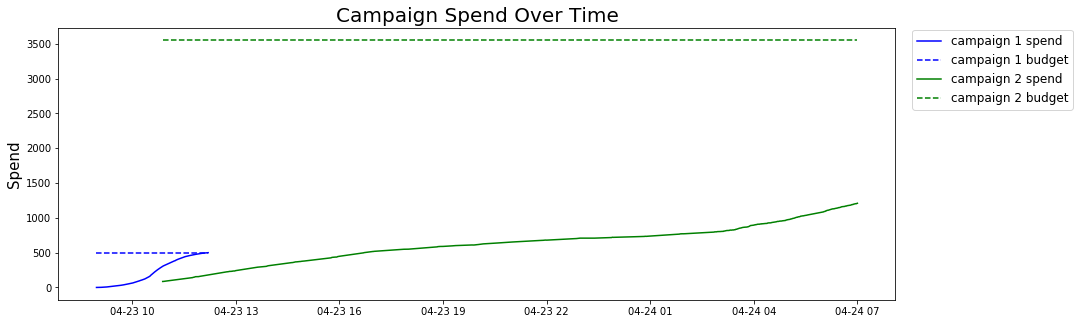

In [177]:
minutes_df = df.groupby(['campaign_id', 'minutes']).last().reset_index()  # grab records from top of the minute

fig, ax = plt.subplots(figsize=(15,5))

for campaign, color in zip((1, 2), ('b', 'g')):
    campaign_df = minutes_df[minutes_df.campaign_id == campaign]
    time = campaign_df.minutes
    spend = campaign_df.campaign_spend
    campaign_budget = campaign_df.campaign_budget.max()
    ax.plot(time, spend, color=color, label='campaign {} spend'.format(campaign))
    ax.plot(time, [campaign_budget for i in time], '--', color=color, label='campaign {} budget'.format(campaign))

ax.set_title('Campaign Spend Over Time', size=20)
ax.set_ylabel('Spend', size=15)
ax.legend(loc=(1.02, 0.7), fontsize=12);

# Question 2
Examining the engagement rate, the rate at which a (chargeable) impression occurs, how are these campaigns different?
- NOTE: I am assuming that chargeable impression here means that the user engaged with the ad (charged != 0) and that engagement rate is chargeable impression per hour (I also explore engagement per served impression later). Since the dataset is a random sample, this metric appears to be a great underestimation. If needed, we can assume that the observed charged amounts can be generalized to the rest of the ad requests and get to a more accurate estimation of the true engagement rate. However, for this exercise, I am simply calculating engagement rate using observed data as the intent is to compare between two campaigns.
- Please refer to the output from code below. On average, campaign 1 sees 38 website clicks per hour compared to 0.1 website click per hour for campaign 2 (both underestimations). Assuming that the random sample for each campaign is roughly an equal percentage of the population, the difference in this metric between campaign 1 and campaign 2 is obvious and doesn't require hypothesis testing. While this metric alone looks good for campaign 1 as it indicates that the campaign is receiving a lot of website clicks, it is possible that the campaign is not spending its money as efficiently as it can. For instance, with a lower bid and detailed targeting, the campaign may attract more users (better targeted) at a lower price throughout a longer period of the day.

# Question 3
How do these campaigns differ in the value of their bid and targeting parameters?
- Please refer to the output from code below. Campaign 1 is an aggressive campaign in that it has a high bid; i.e. it is willing to spend a lot of money for website clicks. Additionally, targeting is broad compared to campaign 2. I can imagine this being a viable marketing/growth strategy given that the campaign will only be charged the second highest price and not the full price of the bid (wash out the competitors while paying only second highest price, making the bet that the second price is significantly lower than the campaign's bid). On the other hand, campaign 2 is conservative with its bid; i.e. it is only willing to spend a small amount of money for website clicks. At the same time, this campaign has more targeting parameters, so the eligible pool of users will be much smaller for this campaign. These two campaigns appear to represent two extremes: campaign 1 represents an aggressive campaign that favors growth over efficiency, and campaign 2 represents a conservative approach that favors efficiency over growth. Neither of them likely achieved the optimal balance between growth and efficiency.

# Question 4
How could campaign 1 change their bid or targeting criteria to help maximize the number of impressions they get per dollar while also spending their whole budget? What about campaign 2?

- Please refer to the output from code below. The fact that campaign 1 burned through its daily budget in three hours indicates that the campaign may benefit from being a bit more conservative with its bid and also targeting a more curated pool of users. If the campaign lowers its bid, the campaign will spend less per website click to generate more website clicks throughout the day. Engagement rate will decrease, but the campaign will be able to run throughout a longer period of the day, eventually leading to greater bottom-line website clicks. Additionally, by adding more targeting parameters, Twitter's algorithm will likely increase pClick, which will increase ECPI, which increases the chance of the campaign's ad winning the auction, and that will increase the number of impressions.
- Campaign 2 suffers from not being able to spend its budget. It was perhaps a bit too conservative in terms of setting its bid and targeting. It is uncertain whether impressions per dollar (which measures efficiency) will increase or decrease with increased bid and less targeting, but campaign 2 should try to increase its bid and decrease the number of targeting parameters in order to spend its daily budget to get more impressions in a day, all the while monitoring impressions per dollar and ensuring that it does not decrease drasticallly.

In [236]:
def engagement_rate(df):
    """
    Given a df of campaign, returns engagement rate as defined by number of chargeable ads / hour
    """
    max_time = campaign_df.datetime.max()
    min_time = campaign_df.datetime.min()
    duration = (max_time - min_time).total_seconds() / 3600  # unit is hour
    charged_ads = len(campaign_df[campaign_df.charged != 0])  # number of ads that resulted in chargeable impression
    return round(charged_ads / duration, 2)

def impressions_per_dollar(df):
    """
    Given a df of campaign, returns impressions per dollar as defined by number of served impressions / dollar
    """
    spend = campaign_df.campaign_spend.max()  # campaign spend is cumulative, so max is total dollars spent
    impressions = len(campaign_df)  # each row in the df is an impression
    return round(impressions / spend, 1)

In [216]:
for campaign in (1, 2):
    campaign_df = df[df.campaign_id == campaign]
    print('Campaign {}'.format(campaign))
    print('engagement rate: {} (underestimate)'.format(engagement_rate(campaign_df)))
    print('bid: {}'.format(campaign_df.bid.max()))
    print('targeting params: {}'.format(campaign_df.matched_targeting.max()))
    print('impressions per dollar: {} (underestimate)'.format(impressions_per_dollar(campaign_df)))
    print()

Campaign 1
engagement rate: 37.68 (underestimate)
bid: 7.5
targeting params: GEO
impressions per dollar: 51.5 (underestimate)

Campaign 2
engagement rate: 0.1 (underestimate)
bid: 1.15
targeting params: ['GEO', 'AGE_BUCKET', 'LANGUAGE', 'GENDER']
impressions per dollar: 1.2 (underestimate)



# Question 5
Let’s look at the data for the app install vs. video view objective. What can you deduce about how these objectives differ in engagement rate, bid, and other key metrics? How might it affect campaign pacing?

- Please refer to the output from code below. There are a few metrics I am omitting for this analysis due to time constraints: incorporating ads seen by users. App install campaigns have higher bids, which may reflect the advertisers' view that app installs are worth more than video views. Also, users are less likely to install an app than to watch a video. While it appears that more app install impressions are served (potentially due to a higher bid), engagement rate and engagement percentage is lower for app installs, again supporting evidence for the statement that users are more likely to watch a video than to install an app. The value of an app install and a video watch is specified by the advertisers, but advertisers should be aware that users are less likely to engage with an ad that asks them to install an app compared to an ad that asks them to watch a video. Consequently, the advertiser to should expect to increase the bid in order to make up for the lower engagement rate and engagement percentage of app installs in order to meet their goals for app installs.
- For this analysis, we also need to ensure that we are making apples to apples comparison between these two objective groups by controlling for other variables such as targeting parameters. One method would be to use linear regression where one independent variable may be the number of targeting parameters. I have unfortunately left this part out due to time constraints.

# Question 6
Are ads from each objective seen by users at the same rate? What might explain the difference?
- Please refer to the output from code below. Ads from app installs are seen at a lower rate than ads from video views. As the rate is defined by seen ads per served impressions, it appears to be related less with winning the bid and more with the ranking of the ads within the feed. One hypothesis is that Twitter's algorithm will put ads with lower pClick on a lower position within the feed. This would mean that users have to scroll more to view app install ads compared to video view ads. One reason for this mechanism within the algorithm may be a desire to "ease" users into ads. Showing an app install ad early on may be more disruptive to the user experience compared to showing a video view ad early on, and further down the feed it becomes less disruptive.

In [257]:
def engagement_per_dollar(df):
    """
    Given a df of campaign, returns engagement per dollar as defined by number of chargeable ads / dollar
    """
    spend = campaign_df.campaign_spend.max()  # campaign spend is cumulative, so max is total dollars spent
    charged_ads = len(campaign_df[campaign_df.charged != 0])  # number of ads that resulted in chargeable impression
    return charged_ads / spend

def engagement_percentage(df):
    """
    Given a df of campaign, returns engagement percentage as defined by chargeable ads / served impressions
    """
    charged_ads = len(campaign_df[campaign_df.charged != 0])  # number of ads that resulted in chargeable impression
    impressions = len(campaign_df)
    return charged_ads / impressions

def seen_percentage(df):
    """
    Given a df of campaign, returns seen percentage as defined by seen ads / served impressions
    """
    seen_ads = len(campaign_df[campaign_df.seen_by_user])  # number of ads that were seen by the user
    impressions = len(campaign_df)
    return seen_ads / impressions    

In [258]:
app_df = df[df.objective == 'APP_INSTALLS']
vid_df = df[df.objective == 'VIDEO_VIEWS']

for obj_df in (app_df, vid_df):  # iterate through the different objectives
    engagement = []
    bid = []
    imp_per_dol = []  # impressions per dollar
    eng_per_dol = []  # engagement per dollar
    eng_perc = []  # engagement percentage
    seen_perc = []
    for campaign in obj_df.campaign_id.unique():  # iterate through the different campaigns in each objective
        campaign_df = obj_df[obj_df.campaign_id == campaign]
        engagement.append(engagement_rate(campaign_df))
        bid.append(campaign_df.bid.iloc[0])
        imp_per_dol.append(impressions_per_dollar(campaign_df))
        eng_per_dol.append(engagement_per_dollar(campaign_df))
        eng_perc.append(engagement_percentage(campaign_df))
        seen_perc.append(seen_percentage(campaign_df))
    avg_engagement = round(sum(engagement) / len(engagement), 2)
    avg_bid = round(sum(bid) / len(bid), 2)
    avg_imp_per_dol = round(sum(imp_per_dol) / len(imp_per_dol), 2)
    avg_eng_per_dol = round(sum(eng_per_dol) / len(eng_per_dol), 2)
    avg_eng_perc = round(sum(eng_perc) / len(eng_perc), 3)
    avg_seen_perc = round(sum(seen_perc) / len(seen_perc), 3)
    print(obj_df.objective.iloc[0])
    print('average engagement_rate: {} (underestimate)'.format(avg_engagement))
    print('average bid: {}'.format(avg_bid))
    print('average impression per dollar: {} (underestimate)'.format(avg_imp_per_dol))
    print('average engagement per dollar: {} (underestimate)'.format(avg_eng_per_dol))
    print('average engagement percentage: {}'.format(avg_eng_perc))
    print('average seen percentage: {}'.format(avg_seen_perc))
    print()

APP_INSTALLS
average engagement_rate: 1.48 (underestimate)
average bid: 1.25
average impression per dollar: 185.0 (underestimate)
average engagement per dollar: 0.12 (underestimate)
average engagement percentage: 0.001
average seen percentage: 0.05

VIDEO_VIEWS
average engagement_rate: 12.14 (underestimate)
average bid: 0.35
average impression per dollar: 11.47 (underestimate)
average engagement per dollar: 0.67 (underestimate)
average engagement percentage: 0.061
average seen percentage: 0.199



# Feedback
- Parts that you enjoyed and parts that you didn’t (and why on both counts)
  - I really enjoyed this exercise. It was fun, and I learned a lot!
- A suggested, specific area for improvement
  - It is not clear to me whether engagement rate in the question is engaged ads per time or engaged ads per served impressions.